In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

## Estimates from Factor Model
We assume a factor model where there are $k$ assets and $T$ time periods (months in our case), m is the common factors (topic weights in our case). $r_{it}$ is the return for asset $i$ at time $t$.

$$
\begin{align}
r_{it}
= &\alpha_i + \sum_{j=1}^{m} \beta_{ij} f_jt + \epsilon_{it}, t = 1, \dots, T, i = 1, \dots, k\\ \\
R_{k \times T} = & B_{k \times m} \cdot coef_{m \times T} + E_{k \times T}
\end{align}
$$

In our analysis, $R_{k \times T}$ is the returns matrix imported, $B_{k \times m}$ is the topic modeling matrix, and $coef_{m \times T}$ is the coefficient matrix computed from the linear regression of returns matrix on topic modeling matrix. $E_{k \times T}$ is the residual matrix.

In our factor model, 

$$\text{Cov}(r) = B \Sigma_{coef} B^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k) \text{ and Var}(\epsilon_i) = \sigma^2_i$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
r_selected = pd.read_csv("data/filtered_r.csv")
# get the mean of all 
r_selected.set_index("name", inplace = True)
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

In [4]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK', 'coDescription',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

### Sent-LDA
We ran the coherence score benchmarking over a range of 3 to 40 topics, incrementing by 3. 

First, we fit the LDA model to all business description using the number of topics selected from coherence score benchmarking. 

Then, we assume each sentence only represents one topic; get the frequency of the topics revealed in the whole document (business description for one company) and calculate the probability of each topics in the whole document. 

#### Coherence Score Plot

![Factor_Model_Coherence_Score.png](images/Factor_Model_Coherence_Score.png)

Based on the above Coherence Score, we choose up to 12 topics since it gives the highest score up to here.

In [5]:
data = df.loc[:,"coDescription_stopwords"].to_list()

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=600)
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=12, random_state=0).fit(tf)

We show the top 10 words by weights in the 12 topics LDA model generates in the below table.

In [7]:
std_func.get_topics(lda, tf_vectorizer, 12)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,could,loan,share,product,investment,gas,hotel,patient,bank,customer,million,cell
1,gas,mortgage,stock,drug,income,oil,facility,treatment,capital,service,tax,cancer
2,regulation,real,note,fda,asset,natural,tenant,trial,institution,data,asset,tumor
3,oil,estate,issued,clinical,reit,production,lease,study,federal,product,net,product
4,future,commercial,preferred,patent,real,reserve,operating,phase,act,solution,income,therapy
5,natural,bank,date,approval,tax,proved,estate,clinical,banking,software,cash,therapeutic
6,price,interest,amount,trial,share,drilling,million,disease,holding,platform,expense,clinical
7,affect,rate,september,application,interest,regulation,real,drug,regulation,technology,value,technology
8,ability,million,per,regulatory,distribution,net,center,therapy,deposit,application,note,research
9,adversely,security,director,candidate,estate,water,portfolio,data,asset,sale,statement,license


#### Frequency of the Topics in Each Sentence

In [8]:
n_components = 12
prob = pd.DataFrame(0, index = df.name, columns = range(n_components))

In [9]:
for j in range(len(df)):
    LIST_sent = pd.Series(df.coDescription[j].split('.')).apply(std_func.lemmatize_sentence).apply(std_func.remove_nums).apply(std_func.remove_stopwords)
    
    X = tf_vectorizer.transform(LIST_sent.tolist())
    sent = lda.transform(X)
    sent_df = pd.DataFrame(sent)
    # drop the values that are smaller than 1/12
    # if the maximum value is 1/12, the probability of each topic in that sentence is the same
    # we cannot determine which topic to choose
    sent_df = sent_df[sent_df.max(axis = 1) > 1/12].reset_index(drop = True)

    for i in range(n_components):
        prob.iloc[j][i] = list(sent_df.idxmax(axis = 1)).count(i)
    
    # calculate the probability
    prob = prob.div(prob.sum(axis=1), axis=0)

In [10]:
prob

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
"MONGODB, INC.",0.014652,0.007326,0.021978,0.036630,0.018315,0.010989,0.040293,0.021978,0.014652,0.739927,0.047619,0.025641
SALESFORCE COM INC,0.010811,0.010811,0.005405,0.016216,0.000000,0.021622,0.037838,0.005405,0.005405,0.821622,0.054054,0.010811
SPLUNK INC,0.010274,0.003425,0.013699,0.020548,0.013699,0.003425,0.023973,0.000000,0.003425,0.839041,0.058219,0.010274
"OKTA, INC.",0.020305,0.000000,0.015228,0.050761,0.015228,0.005076,0.040609,0.000000,0.015228,0.786802,0.030457,0.020305
VEEVA SYSTEMS INC,0.093245,0.012845,0.094196,0.028544,0.035205,0.008563,0.019981,0.010466,0.017602,0.315414,0.352046,0.011893
...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",0.075472,0.084906,0.122642,0.009434,0.471698,0.009434,0.075472,0.000000,0.000000,0.066038,0.084906,0.000000
"CYCLACEL PHARMACEUTICALS, INC.",0.027460,0.000000,0.029748,0.272311,0.011442,0.009153,0.018307,0.308924,0.000000,0.029748,0.013730,0.279176
ZOETIS INC.,0.036519,0.018868,0.074254,0.033475,0.034084,0.013999,0.035301,0.018868,0.020694,0.053561,0.644553,0.015825


#### Demonstration in Pharmaceutical Preparations Industry

In [11]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [12]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

In [13]:
B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

##### Topic Matrix

In [14]:
B_matrix

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
RXI PHARMACEUTICALS CORP,0.039062,0.000000,0.062500,0.183594,0.011719,0.007812,0.011719,0.160156,0.000000,0.089844,0.019531,0.414062
BRISTOL MYERS SQUIBB CO,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"ZYNERBA PHARMACEUTICALS, INC.",0.057471,0.000000,0.011494,0.091954,0.000000,0.000000,0.000000,0.678161,0.000000,0.034483,0.011494,0.114943
WAVE LIFE SCIENCES LTD.,0.053302,0.003476,0.038239,0.238702,0.015064,0.008111,0.016222,0.311703,0.003476,0.060255,0.019699,0.231750
BIODELIVERY SCIENCES INTERNATIONAL INC,0.020921,0.014644,0.085774,0.384937,0.014644,0.020921,0.023013,0.154812,0.012552,0.104603,0.060669,0.102510
...,...,...,...,...,...,...,...,...,...,...,...,...
PROGENICS PHARMACEUTICALS INC,0.056452,0.024194,0.088710,0.036290,0.024194,0.016129,0.004032,0.036290,0.020161,0.032258,0.620968,0.040323
ACHILLION PHARMACEUTICALS INC,0.034200,0.006840,0.073871,0.538988,0.020520,0.004104,0.013680,0.166895,0.019152,0.050616,0.016416,0.054720
IRONWOOD PHARMACEUTICALS INC,0.031185,0.006237,0.101871,0.422037,0.022869,0.004158,0.022869,0.139293,0.018711,0.089397,0.072765,0.068607


In [50]:
r_Pharm = r_selected.T[LIST].T

In [46]:
coef_mat = pd.DataFrame(0, index = r_Pharm.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r_Pharm.index, columns = r_Pharm.columns)

from sklearn.linear_model import LinearRegression

LR = LinearRegression()

for i in range(len(r_Pharm.columns)):
    date = r_Pharm.columns[i]
    r_t_i = r_Pharm[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

##### Coefficient Matrix

In [47]:
coef_mat

,0,1,2,3,4,5,6,7,8,9,10,11
2016-06-30,0.993361,-1.875375,0.195258,-0.337758,1.312631,2.051489,1.238693,-0.392438,-2.489539,-0.470602,-0.236897,0.011175
2016-07-31,-0.587373,2.486985,-0.051766,-0.119139,0.599033,-0.509589,0.034452,-0.130789,-1.116928,-0.347125,0.009258,-0.267018
2016-08-31,-0.088389,-2.184883,0.309753,0.127562,0.202514,-0.612011,-1.106752,0.233257,1.801470,0.803841,0.164920,0.348719
2016-09-30,-0.122107,1.875134,0.171593,0.108377,0.836037,-0.015983,-1.795211,-0.121855,-0.571359,-0.409085,0.001294,0.043164
2016-10-31,-0.236524,-2.536547,-0.143964,-0.035811,-0.187329,1.460662,-0.469362,-0.034221,1.959008,0.200099,0.077996,-0.054007
2016-11-30,-1.151701,1.936744,0.147886,-0.116144,0.417320,-1.095169,-1.533299,-0.054423,1.213919,-0.113511,0.200694,0.147685
2016-12-31,0.483848,-1.161150,-0.100632,-0.193967,-0.265334,0.825843,0.407563,-0.141296,1.436270,-0.580140,-0.186887,-0.524118
2017-01-31,-0.277906,1.977522,0.574171,0.256089,-1.584684,-3.236387,0.679985,0.346124,1.308807,-0.275143,0.050787,0.180636
2017-02-28,0.895630,3.177223,0.208617,-0.125386,-3.827412,-2.817838,0.297242,0.148517,2.594685,-0.329282,-0.044365,-0.177630
2017-03-31,-1.031747,1.838094,0.056902,-0.172604,-0.423448,-1.919721,-0.909357,-0.001361,3.564327,-0.665482,-0.290407,-0.045196


##### Residual Matrix

In [48]:
res_mat

,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
name,,,,,,,,,,,,,,,,,,,,,
RXI PHARMACEUTICALS CORP,0.262405,0.114152,-0.315220,-0.236740,-0.177827,0.269928,-0.191784,-0.329121,0.095537,0.318619,...,0.220603,-0.185255,-0.445625,-0.114524,-0.116156,-0.293724,-0.453810,-0.269186,-0.101216,0.310740
BRISTOL MYERS SQUIBB CO,0.475082,0.064130,-0.361309,-0.243726,0.152744,0.160424,0.254006,-0.476579,0.177058,0.075516,...,0.209973,-0.197573,-0.147057,0.257010,0.066438,-0.345519,-0.451592,0.176296,0.172175,0.261391
"ZYNERBA PHARMACEUTICALS, INC.",0.145502,0.394930,-0.279707,0.550877,0.088627,0.124381,0.433276,-0.223294,0.115620,-0.071356,...,0.170145,0.198419,-0.213405,0.085508,-0.180024,-0.070187,-0.274428,-0.038567,0.034183,-0.086282
WAVE LIFE SCIENCES LTD.,0.538294,0.036058,0.069080,0.265846,0.183459,0.138996,-0.022613,-0.143719,-0.009525,0.026279,...,-0.061396,0.135206,-0.247580,-0.061737,0.169454,0.024497,-0.326006,0.263622,0.145178,0.165504
BIODELIVERY SCIENCES INTERNATIONAL INC,0.338871,0.133021,-0.239107,0.044057,0.029356,-0.267626,0.251020,-0.112620,-0.003217,0.064849,...,0.210341,-0.115562,0.025285,0.215811,-0.044069,-0.220616,-0.354465,0.601298,0.084403,0.322778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PROGENICS PHARMACEUTICALS INC,0.086684,0.333089,-0.079396,-0.110688,-0.058971,0.588569,0.130237,-0.109441,0.141279,-0.024468,...,0.292916,-0.108694,0.015875,0.220498,0.091642,-0.175925,-0.354029,0.154841,-0.001732,0.090930
ACHILLION PHARMACEUTICALS INC,0.174899,0.125090,-0.199385,-0.116924,-0.039598,-0.330180,0.179229,-0.286275,-0.101797,0.107310,...,0.333948,0.000229,-0.248898,0.070302,-0.046840,0.005417,-0.271027,0.131146,0.083880,-0.186465
IRONWOOD PHARMACEUTICALS INC,0.349345,0.142335,-0.276567,0.127594,-0.019962,0.215804,0.176225,-0.328169,0.124622,0.097507,...,0.275418,0.166428,-0.139809,0.220015,0.052340,-0.349619,-0.354794,0.056357,0.131506,0.032834


### Perform Mean-Variance Analysis
We only use the Pharmaceutical Preparations industry data to generate portfolio based on Mean-Variance Analysis.

In [ ]:
!pip install PyPortfolioOpt

In [52]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

#### Mean for Returns in the Pharmaceutical Preparations Industry

In [53]:
mu_Pharm = mu[LIST]
mu_Pharm

name
RXI PHARMACEUTICALS CORP                 -0.099569
BRISTOL MYERS SQUIBB CO                  -0.004359
ZYNERBA PHARMACEUTICALS, INC.            -0.003030
WAVE LIFE SCIENCES LTD.                   0.048065
BIODELIVERY SCIENCES INTERNATIONAL INC    0.025782
                                            ...   
PROGENICS PHARMACEUTICALS INC             0.011256
ACHILLION PHARMACEUTICALS INC            -0.039415
IRONWOOD PHARMACEUTICALS INC              0.001185
EMERGENT BIOSOLUTIONS INC.                0.019928
STEMLINE THERAPEUTICS INC                 0.016350
Length: 124, dtype: float64

#### Covariance Estimated
$$\text{Cov}(r) = B \Sigma_{coef} B^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k)$$

In [54]:
cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index
cov_Factor_Model

name,RXI PHARMACEUTICALS CORP,BRISTOL MYERS SQUIBB CO,"ZYNERBA PHARMACEUTICALS, INC.",WAVE LIFE SCIENCES LTD.,BIODELIVERY SCIENCES INTERNATIONAL INC,"CATALYST PHARMACEUTICALS, INC.",AXOVANT SCIENCES LTD.,ENDO INTERNATIONAL PLC,NATURES SUNSHINE PRODUCTS INC,GALECTIN THERAPEUTICS INC,...,ACADIA PHARMACEUTICALS INC,EVOKE PHARMA INC,ALEXION PHARMACEUTICALS INC,FIBROGEN INC,PERRIGO CO PLC,PROGENICS PHARMACEUTICALS INC,ACHILLION PHARMACEUTICALS INC,IRONWOOD PHARMACEUTICALS INC,EMERGENT BIOSOLUTIONS INC.,STEMLINE THERAPEUTICS INC
name,,,,,,,,,,,,,,,,,,,,,
RXI PHARMACEUTICALS CORP,0.091018,0.025936,0.024239,0.024279,0.023044,0.022966,0.021045,0.027350,0.016342,0.026070,...,0.023351,0.021643,0.021218,0.021940,0.021437,0.014842,0.023302,0.023962,0.023403,0.025038
BRISTOL MYERS SQUIBB CO,0.025936,0.102207,0.030478,0.026708,0.027965,0.031678,0.020175,0.031394,0.018056,0.032130,...,0.031180,0.029782,0.028394,0.026088,0.023748,0.020559,0.032511,0.031215,0.028663,0.032330
"ZYNERBA PHARMACEUTICALS, INC.",0.024239,0.030478,0.092123,0.024572,0.023961,0.027483,0.018786,0.027693,0.016456,0.031979,...,0.028099,0.028440,0.025678,0.022804,0.022095,0.017612,0.027403,0.026725,0.024390,0.028089
WAVE LIFE SCIENCES LTD.,0.024279,0.026708,0.024572,0.072423,0.021919,0.023413,0.018598,0.025736,0.015475,0.025895,...,0.023741,0.022669,0.021711,0.020770,0.020067,0.014934,0.023552,0.023572,0.022397,0.024450
BIODELIVERY SCIENCES INTERNATIONAL INC,0.023044,0.027965,0.023961,0.021919,0.081116,0.023675,0.019132,0.026765,0.014708,0.025157,...,0.023623,0.022523,0.020897,0.021376,0.020647,0.014970,0.023588,0.023632,0.022785,0.024491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PROGENICS PHARMACEUTICALS INC,0.014842,0.020559,0.017612,0.014934,0.014970,0.016881,0.009857,0.015417,0.010227,0.019207,...,0.016980,0.017071,0.015831,0.014134,0.014171,0.051277,0.018037,0.017566,0.014973,0.018059
ACHILLION PHARMACEUTICALS INC,0.023302,0.032511,0.027403,0.023552,0.023588,0.026947,0.016322,0.026448,0.016860,0.029610,...,0.027177,0.026454,0.025338,0.021845,0.020857,0.018037,0.074014,0.027149,0.024332,0.028029
IRONWOOD PHARMACEUTICALS INC,0.023962,0.031215,0.026725,0.023572,0.023632,0.026195,0.017283,0.027088,0.016891,0.028804,...,0.026494,0.025554,0.024367,0.021966,0.021439,0.017566,0.027149,0.066640,0.024321,0.027355


#### Efficient Frontier - Pharmaceutical Preparations

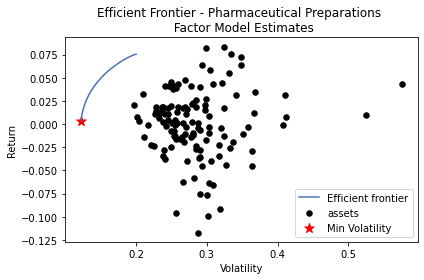

In [55]:
ef1 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - Pharmaceutical Preparations \n Factor Model Estimates")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns_Pharmaceutical_Preparations.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility Portfolio

###### Performance

In [56]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.4%
Annual volatility: 12.3%
Sharpe Ratio: -0.13


###### Weights

In [57]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Pharmaceutical_Preparations.csv", index = False)

In [58]:
pd.read_csv("data/min_vol_factor_model_Pharmaceutical_Preparations.csv")

,Company_Name,Weight
0,AXOVANT SCIENCES LTD.,0.02372
1,NATURES SUNSHINE PRODUCTS INC,0.13263
2,MANNKIND CORP,0.00222
3,"LEXICON PHARMACEUTICALS, INC.",0.05025
4,ANI PHARMACEUTICALS INC,0.06101
5,"ACLARIS THERAPEUTICS, INC.",0.05895
6,"PACIRA PHARMACEUTICALS, INC.",0.03613
7,"CONCERT PHARMACEUTICALS, INC.",0.02974
8,XOMA CORP,0.05504
9,"TELIGENT, INC.",0.08129


### Results for the Other 4 Industries

In [59]:
SIC_list = [7372, 1311, 6798, 6022]
SIC_desc = ['Prepackaged Software (mass reproduction of software)', 'Crude Petroleum and Natural Gas', 
           'Real Estate Investment Trusts', 'State Commercial Banks (commercial banking)']

#### Prepackaged Software (mass reproduction of software)

In [60]:
SIC = SIC_list[0]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

LR = LinearRegression()

for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

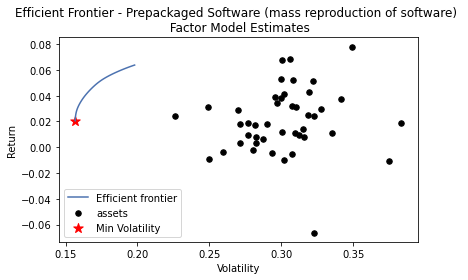

In [61]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png', dpi=200, bbox_inches='tight')
#plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png](images/Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png)

##### Min Volatility Portfolio

###### Performance

In [62]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 2.1%
Annual volatility: 15.7%
Sharpe Ratio: 0.00


###### Weights

In [63]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Prepackaged_Software.csv", index = False)

In [64]:
pd.read_csv("data/min_vol_factor_model_Prepackaged_Software.csv")

,Company_Name,Weight
0,"BLACK KNIGHT, INC.",0.00538
1,MICROSTRATEGY INC,0.13768
2,"2U, INC.",0.19685
3,QUMU CORP,0.04424
4,APPFOLIO INC,0.01773
5,INTELLIGENT SYSTEMS CORP,0.01948
6,SPS COMMERCE INC,0.01852
7,"ENDURANCE INTERNATIONAL GROUP HOLDINGS, INC.",0.11290
8,"BRIDGELINE DIGITAL, INC.",0.03550
9,REALPAGE INC,0.02096


#### Crude Petroleum and Natural Gas
When we conduct the same analysis, there is no weight shown. Efficient frontier cannot be found.

In [65]:
SIC = SIC_list[1]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

LR = LinearRegression()

for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

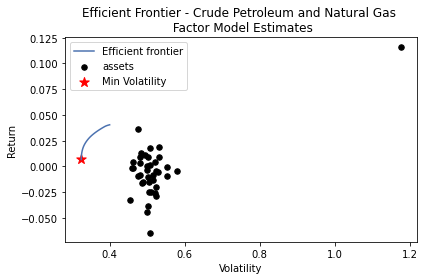

In [66]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png', dpi=200, bbox_inches='tight')
#plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png](images/Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png)

##### Min Volatility Portfolio

###### Performance

In [67]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.7%
Annual volatility: 32.4%
Sharpe Ratio: -0.04


###### Weights

In [68]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Crude_Petroleum_and_Natural_Gas.csv", index = False)

In [69]:
pd.read_csv("data/min_vol_factor_model_Crude_Petroleum_and_Natural_Gas.csv")

,Company_Name,Weight
0,CALIFORNIA RESOURCES CORP,0.16181
1,SM ENERGY CO,0.07055
2,GULFPORT ENERGY CORP,0.00625
3,ISRAMCO INC,0.03757
4,ANTERO RESOURCES CORP,0.08452
5,CALLON PETROLEUM CO,0.07632
6,ABRAXAS PETROLEUM CORP,0.02884
7,"DIAMONDBACK ENERGY, INC.",0.03588
8,SANCHEZ ENERGY CORP,0.00736
9,CARRIZO OIL & GAS INC,0.02877


#### Real Estate Investment Trusts

In [74]:
SIC = SIC_list[2]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

LR = LinearRegression()

for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

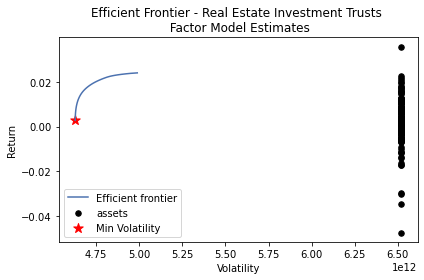

In [75]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png](images/Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png)

##### Min Volatility Portfolio

###### Performance

In [76]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.3%
Annual volatility: 462835897203028.4%
Sharpe Ratio: -0.00


###### Weights

In [77]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Real_Estate_Investment_Trusts.csv", index = False)

In [78]:
pd.read_csv("data/min_vol_factor_model_Real_Estate_Investment_Trusts.csv")

,Company_Name,Weight
0,PREFERRED APARTMENT COMMUNITIES INC,0.00781
1,"ALEXANDER & BALDWIN, INC.",0.00781
2,"SABRA HEALTH CARE REIT, INC.",0.00781
3,ARES COMMERCIAL REAL ESTATE CORP,0.00781
4,ELLINGTON RESIDENTIAL MORTGAGE REIT,0.00781
...,...,...
123,SAUL CENTERS INC,0.00781
124,"UDR, INC.",0.00781
125,CAPSTEAD MORTGAGE CORP,0.00781
126,"JERNIGAN CAPITAL, INC.",0.00781


#### State Commercial Banks (commercial banking)

In [82]:
SIC = SIC_list[3]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

LR = LinearRegression()

for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

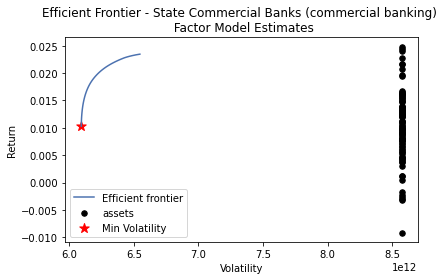

In [83]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png](images/Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png)

##### Min Volatility Portfolio

###### Performance

In [84]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.0%
Annual volatility: 609411148403690.2%
Sharpe Ratio: -0.00


###### Weights

In [85]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_State_Commercial_Banks.csv", index = False)

In [86]:
pd.read_csv("data/min_vol_factor_model_State_Commercial_Banks.csv")

,Company_Name,Weight
0,CITIZENS FINANCIAL GROUP INC/RI,0.01064
1,BRYN MAWR BANK CORP,0.01064
2,UNITY BANCORP INC /NJ/,0.01064
3,"AUBURN NATIONAL BANCORPORATION, INC",0.01064
4,CVB FINANCIAL CORP,0.01064
...,...,...
89,HEARTLAND FINANCIAL USA INC,0.01064
90,PACIFIC PREMIER BANCORP INC,0.01064
91,CATHAY GENERAL BANCORP,0.01064
92,COMMERCE BANCSHARES INC /MO/,0.01064
